In [10]:
#basic imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from unyt import kW, minute, hr, day, MW
import sys

# osier imports
from osier import DispatchModel
from osier import CapacityExpansion
import osier.tech_library as lib

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination.ftol import MultiObjectiveSpaceTermination
from pymoo.termination.robust import RobustTermination

# automatically set the solver
if "darwin" in sys.platform:
    solver = 'cplex_direct'
elif "linux" in sys.platform:
    solver = "cbc"
else:
    solver = "cbc"

print(f"Solver set: {solver}")

Solver set: cplex_direct


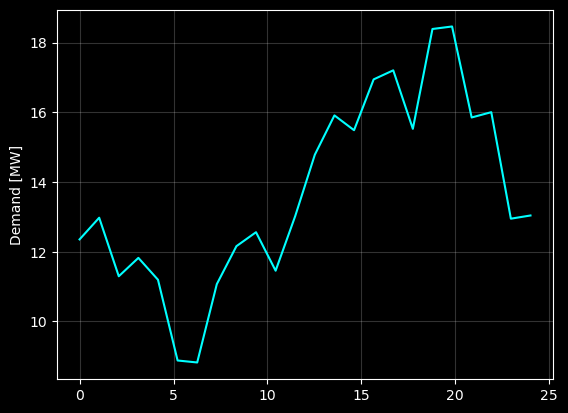

In [11]:
n_hours = 24  # hours per day
n_days = 1  # days to model
N = n_hours*n_days  # total number of time steps
phase_shift = 0  # horizontal shift [radians]
base_shift = 2  # vertical shift [units of demand]
hours = np.linspace(0,N,N)
total_demand = 328.16  # [MWh], sets the total demand [units of energy]

demand = (np.sin((hours*np.pi/n_hours*2+phase_shift))*-1+np.ones(N)*(base_shift+1))

np.random.seed(1234) # sets the seed for repeatability

noise = np.random.random(N)
demand += noise

demand = demand/demand.sum() * total_demand  # rescale

with plt.style.context("dark_background"):
    plt.plot(hours, demand, color='cyan')
    plt.ylabel('Demand [MW]')
    plt.grid(alpha=0.2)
    plt.show()

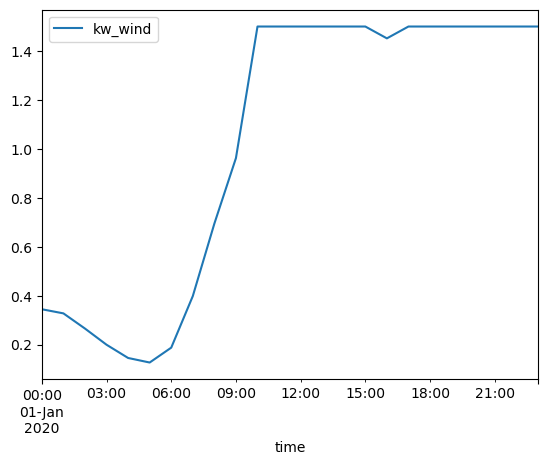

In [12]:
#importing wind data
url = "https://raw.githubusercontent.com/samgdotson/2021-dotson-ms/refs/heads/master/data/nsrdb_data/windHistory_2020.csv"
wind_power_data = pd.read_csv(url, usecols=['time', 'kw_wind'], parse_dates=True,index_col='time')
wind_power = wind_power_data.loc['2020-01-01']#'2020-01-02']
#wind_power2 = wind_power_data.loc['2020-01-02']
wind_power.plot();plt.show()

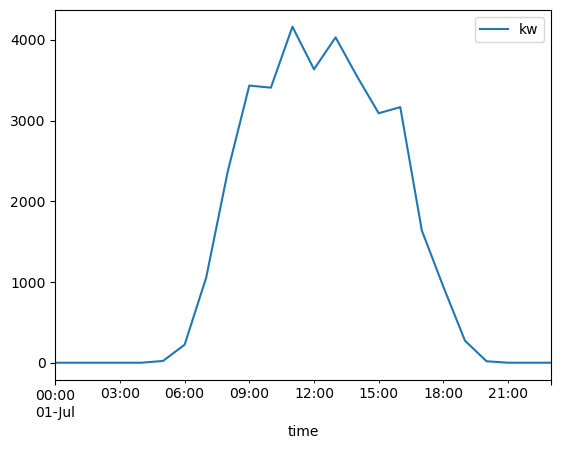

In [13]:
url = "https://raw.githubusercontent.com/samgdotson/2021-dotson-ms/refs/heads/master/data/solarfarm_data.csv"
solar_power = pd.read_csv(url, usecols=['time', 'kw'], parse_dates=True, index_col='time')

# choose a single day
solar_day = solar_power.loc['2016-07-01']
solar_day.plot();plt.show()

In [14]:
#getting the energy production values to run in the model

#solar power
solar_day_ener = solar_day['kw'].values
df_solar = pd.DataFrame(solar_day_ener, columns=['Energy'])
solar_ener = df_solar['Energy'].values

#wind power
wind_ener = wind_power['kw_wind'].values

In [15]:
#creating energy mix

#based off osier documentation, we need to include geothermal and add the capacity for coal
#adding capacity of coal, based on research
from osier.tech_library import coal

#finally, create the necessary energy mix
UIUC_mix = [lib.natural_gas,lib.coal,lib.solar,lib.wind]
display(UIUC_mix)

[NaturalGas_Conv: 8375.1331 MW,
 Coal_Conv: 0.0 MW,
 SolarPanel: 2810.3015 MW,
 WindTurbine: 0.0 MW]

In [8]:
#now wanting to do a multi-objective run
#considered total cost, lets consider limitng CO2 emissions
from osier import annual_emission, total_cost
problem2 = CapacityExpansion(technology_list = UIUC_mix,
                            demand=demand*MW,
                            solar=solar_ener,
                            wind=wind_speed,
                            upper_bound= 1 / lib.solar.capacity_credit,
                            objectives = [total_cost,annual_emission],
                            solver=solver)  # the objectives must be passed as a LIST of functions!

In [9]:
algorithm = NSGA2(pop_size=20)
termination = RobustTermination(MultiObjectiveSpaceTermination(tol=0.05, n_skip=5), period=20)
import time
start = time.perf_counter()
res = minimize(problem2,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
end = time.perf_counter()
print(f"The simulation took {(end-start)/60:.3f} minutes.")

KeyboardInterrupt: 

In [16]:
#displaying multi-objective results
display(res.F),display(res.X)

array([[9.48449077e-01, 1.60620729e-04],
       [3.55584917e+00, 3.83297976e-06],
       [1.44490527e+00, 1.01076249e-04],
       [1.27544699e+00, 1.24417899e-04],
       [2.06009028e+00, 4.74256108e-05],
       [2.18861471e+00, 3.37672692e-05],
       [3.23349368e+00, 8.55442758e-06],
       [1.89837774e+00, 5.87994415e-05],
       [1.78530102e+00, 7.49910312e-05],
       [2.37705387e+00, 2.61982869e-05],
       [2.51665969e+00, 2.22008932e-05],
       [2.73346076e+00, 1.76653348e-05],
       [3.00920322e+00, 1.05168538e-05],
       [1.60414946e+00, 8.65962590e-05],
       [9.99934751e-01, 1.55758009e-04],
       [3.49679536e+00, 5.47930797e-06],
       [2.83742628e+00, 1.23567585e-05],
       [1.81376635e+00, 6.64734081e-05],
       [1.14572595e+00, 1.47845770e-04],
       [1.61444092e+00, 8.58952274e-05]])

array([[9.87663602e-01, 7.73087388e-03, 1.56268487e-03, 1.63679915e-02,
        8.51635344e-05],
       [1.22717602e-03, 6.84157774e-04, 6.98229415e-03, 7.85427724e-01,
        7.17849131e-01],
       [9.33063859e-01, 1.33989099e-03, 8.63512887e-01, 1.78297079e-02,
        7.95461754e-05],
       [9.87663602e-01, 4.66935414e-03, 4.88650421e-01, 1.87984599e-02,
        4.63799704e-03],
       [5.72631758e-01, 1.47499857e-03, 3.31395143e-01, 6.96988892e-01,
        8.54644041e-02],
       [4.41405349e-01, 1.34276211e-03, 3.35641818e-01, 9.20107164e-01,
        6.01118338e-02],
       [7.08814227e-02, 1.33989099e-03, 4.80094816e-01, 1.49077474e+00,
        1.94307334e-01],
       [5.92790075e-01, 1.23679750e-03, 2.88114849e-01, 7.06702639e-01,
        3.52422391e-02],
       [7.35524882e-01, 1.47915036e-04, 2.84697145e-01, 4.91792461e-01,
        5.87565091e-02],
       [4.03025705e-01, 1.33795823e-03, 5.93774558e-01, 1.06655303e+00,
        1.19572392e-02],
       [4.03025705e-01, 3.5711

(None, None)

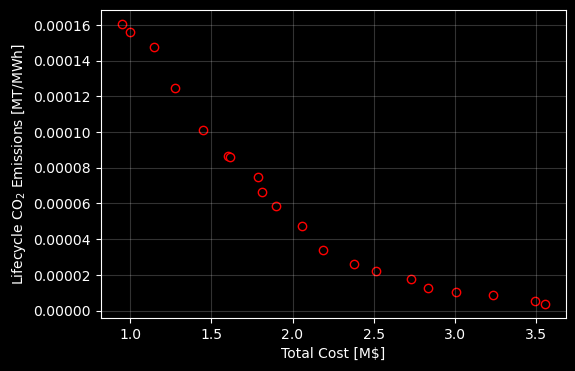

In [17]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    ax.scatter(res.F[:,0], res.F[:,1], edgecolors='red', facecolors='k')
    ax.set_ylabel(r"Lifecycle CO$_2$ Emissions [MT/MWh]")
    ax.set_xlabel(r"Total Cost [M\$]")
    ax.grid(alpha=0.2)

    plt.show()